# Example notebook for using LRP

In [1]:
import numpy as np
import pandas as pd
from keras.utils import plot_model
from keras.models import Model, load_model
from keras.layers import Input, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D
from tensorflow.python.ops import gen_nn_ops
from sklearn.model_selection import StratifiedShuffleSplit
from keras.layers.pooling import MaxPooling2D
import tensorflow as tf
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.
C:\Users\robin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\robin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\robin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\robin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

## MNIST Dataset

The MNIST dataset is 28x28 mono pictures of 10 classes.

In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train = np.eye(np.max(y_train)+1)[y_train]
y_test = np.eye(np.max(y_test)+1)[y_test]
x_train = (((x_train/255)*2)-1)
x_train = np.expand_dims(x_train, axis=-1)
x_test = (((x_test/255)*2)-1)
x_test = np.expand_dims(x_test, axis=-1)

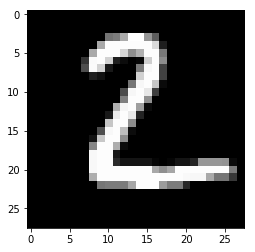

In [3]:
plt.imshow((x_test[1,:,:,0]+1)/2, cmap="gray")

In [4]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [5]:
dependencies = {"f1": f1}
classifier = load_model("./models/mnist_model_2.hdf5", custom_objects=dependencies)

In [6]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0, # Randomly zoom image 
        width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## Layerwise relevance propagation

Step1: import lrp library

In [7]:
import lrp

Step2: get one sample from data generator

In [8]:
sample = datagen.flow(x_train,y_train,1)
img = sample[0][0].reshape(sample[0][0].shape[1:])
label = sample[0][1].reshape(10)

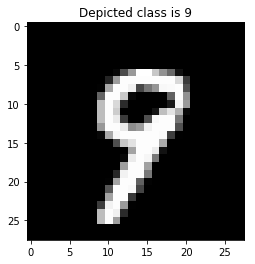

In [9]:
plt.imshow(((img+1)/2)[:,:,0],cmap='gray')
_ = plt.title("Depicted class is "+str(np.argmax(label)))

In [10]:
R = lrp.relprop(classifier,img, label, a=3, b=2, verbose = True)

calculating LRP of  <keras.engine.training.Model object at 0x00000186DD67B6D8>
###################
getting values
propagating relevance regarding classification:  9
In layer  -1  :  <keras.layers.core.Dense object at 0x0000018683F0B400>  check-value:  0.9991706602025472
In layer  -2  :  <keras.layers.core.Dense object at 0x0000018683F0B358>  check-value:  0.9988985121933962
In layer  -3  :  <keras.layers.core.Flatten object at 0x0000018683F0B2E8>  check-value:  0.9988985121933962
In layer  -4  :  <keras.layers.pooling.MaxPooling2D object at 0x00000186DD67B780>  check-value:  0.9960025720114194
In layer  -5  :  <keras.layers.convolutional.Conv2D object at 0x0000018683EE72B0>  check-value:  0.9960747
In layer  -6  :  <keras.layers.convolutional.Conv2D object at 0x0000018683EE73C8>  check-value:  1.0001577
In layer  -7  :  <keras.layers.pooling.MaxPooling2D object at 0x0000018683EE7B00>  check-value:  0.8081943057313304
In layer  -8  :  <keras.layers.convolutional.Conv2D object at 0x00000

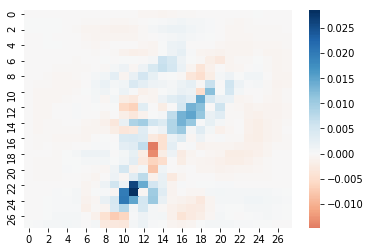

In [11]:
sns.heatmap(R[0,:,:,0],center=0, vmax=np.max(R), vmin=np.min(R),cmap="RdBu")